In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer Learning with TensorFlow Hub

Now a days, large image classification models can easily have millions of parameters. Training such models from scratch requires a lot of data and a lot of computing power. Transfer learning is a technique that involves leaving the bulk of a model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs. Transfer learning can not only decrease your training time but can also increase your accuracy. 

In this notebook, we'll go over a very common scenario where we build a Keras model for classifying images of cats and dogs by using a pre-trained MobileNet feature vector from TensorFlow Hub. The feature vector can be optionally "fine-tuned" alongside the newly added classifier.

# Setup

In [3]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.12.0


## Download the Cats vs. Dogs Dataset

We will download the [Cats vs. Dogs dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) using TensorFlow Datasets. We will use a training set, a validation set, and a test set. Since the Cats vs. Dogs dataset doesn't have a validation or test split, we will create our own splits from the training set. We will use the first 80\% for training, the next 10\% for validation, and the last 10\% for testing.

In [5]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## Explore the Data 

Let's take a moment to look at the data.

In [6]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))
print('\u2022 {:,} images'.format(num_examples))

The Dataset has a total of:
• 2 classes
• 23,262 images


The labels are either 0 or 1, where 0 is a cat, and 1 is a dog. We will create a list with the corresponding class names, so that we can map labels to class names later on.

In [7]:
class_names = ['cat', 'dog']

Let's see what one of the images looks like.

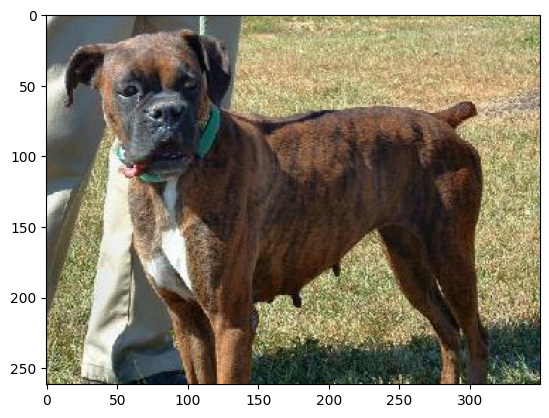

The label of this image is: 1
The class name of this image is: dog


In [8]:
for image, label in train_examples.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

## Load the TensorFlow Hub Feature Vector

Below we can select the feature vector we want to use. The feature vector will be wrapped in a `hub.KerasLayer`.

In [9]:
model_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}

handle_base, pixels, FV_SIZE = model_selection

IMAGE_SIZE = (pixels, pixels)

# if you are running the notebook on Colab
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

# # if you are running the notebook on your local machine
# MODULE_HANDLE ="./models/tf2-preview_mobilenet_v2_feature_vector_4".format(handle_base)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,))

print("Using {} with input size {} and output dimension {}.".format(handle_base, IMAGE_SIZE, FV_SIZE))

Using mobilenet_v2 with input size (224, 224) and output dimension 1280.


## Build Pipeline

In [10]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label
    
BATCH_SIZE =  32

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE)

## Build the Model

Now we wrap the `feature_extractor` in a `tf.keras.Sequential` model, and add a new classification layer.

In [11]:
print("Building model with: ", MODULE_HANDLE, '\n')

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Building model with:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## (Optional) Perform Fine Tuning

In [12]:
do_fine_tuning = False #@param {type:"boolean"}

if do_fine_tuning:
    feature_extractor.trainable = True    
else:
    feature_extractor.trainable = False

## Configure the Model for Training

If we choose to do fine-tuning, we will use an `SGD` optimizer, otherwise, we will use the `adam` optimizer.

In [13]:
if do_fine_tuning:
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)
else:
    optimizer = 'adam'
    
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the Model

In [14]:
EPOCHS = 1

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

582/582 [==============================] - 62s 77ms/step - loss: 0.0520 - accuracy: 0.9828 - val_loss: 0.0362 - val_accuracy: 0.9862


## Evaluate the Model

We will now see how well our model performs on the testing set.

In [15]:
eval_results = model.evaluate(test_batches, verbose=0)

for metric, value in zip(model.metrics_names, eval_results):
    print(metric + ': {:.4}'.format(value))

loss: 0.0298
accuracy: 0.9893
